In [41]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [88]:
df = pd.read_csv("../data/apple.csv")

In [89]:
# df = df.drop(columns=['symbol'])
df.Date = pd.to_datetime(df.Date)
df = df.sort_values(by="Date")

In [90]:
df = df.set_index('Date')

In [91]:
df['Close/Last'] = df['Close/Last'].apply(lambda x: float(x.strip('$')))
df['Open'] = df['Open'].apply(lambda x: float(x.strip('$')))
df['High'] = df['High'].apply(lambda x: float(x.strip('$')))
df['Low'] = df['Low'].apply(lambda x: float(x.strip('$')))


In [92]:
df.head()

,Close/Last,Volume,Open,High,Low
Date,,,,,
2012-06-25,20.3845,303851958,20.6179,20.7072,20.3704
2012-06-26,20.4295,276499693,20.4047,20.5175,20.2618
2012-06-27,20.5179,202948315,20.5357,20.5979,20.4257
2012-06-28,20.3232,282288047,20.4168,20.5000,20.2004
2012-06-29,20.8572,420527352,20.6429,20.8572,20.5089


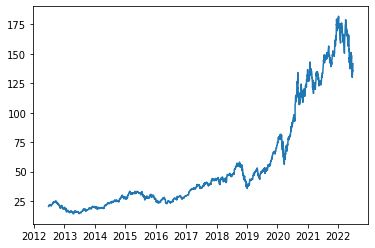

In [93]:
plt.plot(df.index, df['Close/Last'])

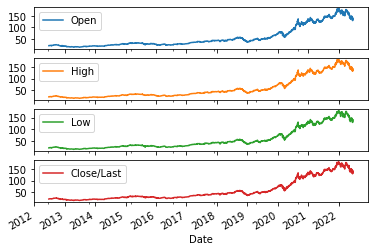

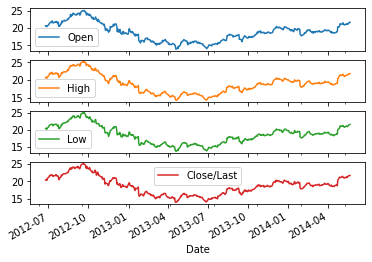

In [95]:
plot_cols = ['Open', 'High', 'Low', 'Close/Last']
plot_features = df[plot_cols]
# plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
# plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

# Using PyTorch Forecasting

In [96]:
import os
import warnings
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [97]:
# df['time_idx'] = df.index.year * 12 + df.index.month + df.index.day
# df['time_idx'] = df.index.map(pd.Timestamp.timestamp)
df['time_idx'] = range(len(df))
df["time_idx"] -= df["time_idx"].min()

In [99]:
df["month"] = df.index.month.astype(str).astype("category")  # categories have be strings
df["log_volume"] = np.log(df.Volume + 1e-8)
# df["avg_volume_by_sku"] = df.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
# df["avg_volume_by_agency"] = df.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")


In [102]:
df['symbol'] = 'AAPL'

In [100]:
df.head()

,Close/Last,Volume,Open,High,Low,time_idx,month,log_volume
Date,,,,,,,,
2012-06-25,20.3845,303851958,20.6179,20.7072,20.3704,0,6,19.532051
2012-06-26,20.4295,276499693,20.4047,20.5175,20.2618,1,6,19.437720
2012-06-27,20.5179,202948315,20.5357,20.5979,20.4257,2,6,19.128462
2012-06-28,20.3232,282288047,20.4168,20.5000,20.2004,3,6,19.458439
2012-06-29,20.8572,420527352,20.6429,20.8572,20.5089,4,6,19.857020


In [114]:
max_prediction_length = 1  # function of time step, forecasting 6 days into the future
max_encoder_length = 24
training_cutoff = df["time_idx"].max() - max_prediction_length

In [115]:
training = TimeSeriesDataSet(
    data=df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Close/Last",
    group_ids=["symbol"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Open",
        "High",
        "Low",
        "Close/Last",
        "Volume",
        "log_volume",
    ],
    target_normalizer=GroupNormalizer(groups=["symbol"], transformation="softplus"),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [116]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [117]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


3.3899993896484375

In [118]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\loops\utilities.py:91: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 22.7k


c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new a

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\trainer\trainer.py:1933: PossibleUserWarning: The number of training b

suggested learning rate: 0.2454708915685031


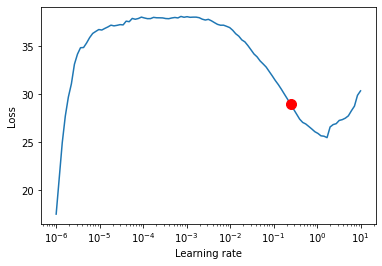

C:\Users\Pedro\AppData\Local\Temp\ipykernel_5048\450857479.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [119]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [120]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.09,
    hidden_size=16,
    attention_head_size=8,
    dropout=0.05,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 22.3k


c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new a

In [121]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 73    
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.4 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lst

Epoch 25: 100%|██████████| 20/20 [00:05<00:00,  3.54it/s, loss=0.811, v_num=6, train_loss_step=0.757, val_loss=1.410, train_loss_epoch=0.822]


In [122]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Pedro\Anaconda3\envs\pedrino\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [123]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(3.2717)

In [124]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

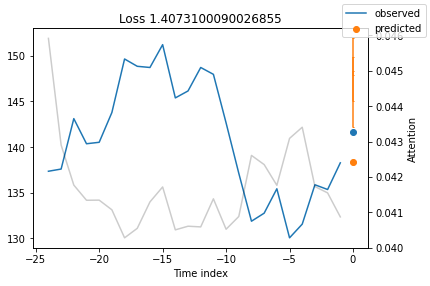

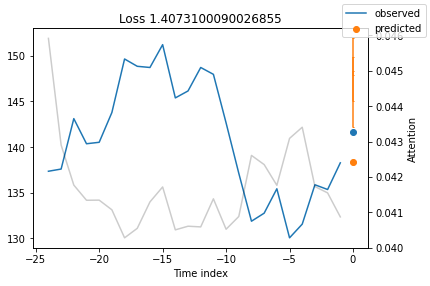

In [125]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)